In [ ]:
!nvidia-smi

Mon Feb 15 18:11:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import subprocess
import sys

from glob import glob
from shutil import copyfile
from google.colab import drive
from tqdm.notebook import tnrange
from tqdm import tqdm
from numba import jit, prange
import numba

# Consts

In [ ]:
weights_zip_path = "/content/drive/MyDrive/Final Project/Models/Handwriting Generation/IAM_weights.tar.gz"
test_styles_path = "/content/IAM_weights/IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG/test_styles_175000.pkl"
checkpoint_path = "/content/IAM_weights/IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG/checkpoint-iteration175000.pth"
test_results_path = "/content/test_resutls"
text_path = "/content/handwriting_line_generation/data/english_text.txt"
config_path = "/content/handwriting_line_generation/configs/cf_IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG.json"
iam_path = "/content/IAM"
iam_zip_path = "/content/drive/MyDrive/Final Project/Datasets/IAM/IAM.zip"
code_zip_path = "/content/drive/MyDrive/Final Project/Code Files/handwriting_line_generation.zip"
code_path = "/content/handwriting_line_generation"
data_path = f'{code_path}/data'
all_lines_path = "/content/lines"
all_words_path = "/content/words"
gt_train_path = '/content/handwriting_line_generation/gan.iam.tr_va.gt.filter27'
gt_test_path = '/content/handwriting_line_generation/gan.iam.test.gt.filter27'
new_ds_fakes_path = '/content/drive/MyDrive/Final Project/Datasets/FakeRealWordDs3/fake_words'
new_ds_reals_path = '/content/drive/MyDrive/Final Project/Datasets/FakeRealWordDs3/real_words'
zipped_new_ds_path = '/content/drive/MyDrive/Final Project/Datasets/FakeRealWordDs2.zip'
ganwriting_real_fake_zip = "/content/drive/MyDrive/Final Project/Datasets/FakeRealWordDs1.zip"
new_fake_real_ds = "/content/drive/MyDrive/Final Project/Datasets/FakeRealWordDs"

# Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Paths' Arrangements

In [ ]:
!tar -C "/content/" -zxvf "$weights_zip_path"

IAM_weights/IAM_auto_2tight_newCTC/
IAM_weights/IAM_auto_2tight_newCTC/checkpoint-iteration60000.pth
IAM_weights/IAM_hwr_cnnOnly_batchnorm_aug/
IAM_weights/IAM_hwr_cnnOnly_batchnorm_aug/checkpoint-iteration100000.pth
IAM_weights/IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG/
IAM_weights/IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG/test_styles_175000.pkl
IAM_weights/IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG/checkpoint-iteration175000.pth


In [ ]:
!mkdir "$test_results_path"

In [ ]:
!unzip "$iam_zip_path" -d "/content"

In [ ]:
!unzip "$code_zip_path" -d "/content"

# Generate handwriting given the test_styles .pkl file

In [ ]:
%cd "/content/handwriting_line_generation"

/content/handwriting_line_generation


Create a text file to generate

In [ ]:
def text_to_file(path, text):
    """
    Given a path and the desired input text as strings,
    write a text file that contains the given text 
    """

    with open(path, 'w') as f:
        f.write(text)

In [ ]:
text_to_file(text_path, "Please work because we need a high grade")

In [ ]:
!python3 generate.py -c "$checkpoint_path" -d "$test_results_path" -g 0 -T -f "$config_path" -s "$test_styles_path"

# Generating handwriting fake dataset

In [ ]:
def arrange_iam_lines_or_words(in_path, out_path):
    """
    Given an in_path to the IAM lines/words dataset,
    arrange the images together in single directory according to out_path 
    """

    assert os.path.exists(in_path), "Invalid input path"
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    dirs_1 = glob(os.path.join(in_path, '*'))
    for d1 in tqdm(dirs_1):
        dirs_2 = glob(os.path.join(d1, '*'))
        for d2 in dirs_2:
            line_files_paths = glob(os.path.join(d2, '*'))
            for lp in line_files_paths:
                os.system(f'cp {lp} {out_path}')

In [ ]:
arrange_iam_lines_or_words(os.path.join(iam_path, 'lines'), all_lines_path)

100%|██████████| 76/76 [01:29<00:00,  1.18s/it]


In [ ]:
!zip -r '/content/lines.zip' '/content/lines'

In [ ]:
!cp '/content/lines.zip' '/content/drive/MyDrive/Final Project/Datasets/'

In [ ]:
arrange_iam_lines_or_words(os.path.join(iam_path, 'words'), all_words_path)

100%|██████████| 76/76 [17:57<00:00, 14.18s/it]


In [ ]:
import os
import json
import logging
import argparse
import torch
import math
import pickle
import cv2
import sys
import random, re, csv
import torch
from model import *
from model.metric import *
from model.loss import *
from logger import Logger
from trainer import *
from data_loader import getDataLoader
from datasets.text_data import TextData
from evaluators import *
from collections import defaultdict
from utils import string_utils
from utils.util import ensure_dir
from glob import glob
from torch.utils.data import DataLoader, Dataset

logging.basicConfig(level=logging.INFO, format='')
img_height = 64
img_width = 216

info = {
    "char_file": "/content/handwriting_line_generation/data/IAM_char_set.json",
    "arch": "HWWithStyle", 
    "model": {
        "num_class": 80,
        "generator": "PureGen",
        "gen_append_style": True,
        "gen_dim": 256,
        "gen_use_skips": True,
        "hwr": "CNNOnly batchnorm",
        "pretrained_hwr": "/content/IAM_weights/IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG/checkpoint-iteration175000.pth",
        "hwr_frozen": True,
        "count_std": 0.0,
        "dup_std": 0.0,
        "style": "char",
        "style_norm":"group",
        "style_activ":"relu",
        "style_dim": 128,
        "char_style_dim": 0,
        "char_style_window": 2,
        "average_found_char_style": 1.0,
        "style_extractor_dim": 64,
        "char_style_extractor_dim": 128,
        "num_keys": None,
        "global_pool": True,
        "attention": False,
        "discriminator": "condAP wide, no style, no global, use low, no cond",
        "disc_dim": 64,
        "spacer": "CNN duplicates",
        "spacer_fix_dropout": True
    },
    "char_to_idx": {" ": 1, "!": 2, "\"": 3, "#": 4, "&": 5, "'": 6, "(": 7, ")": 8, "*": 9, "+": 10, ",": 11, "-": 12, ".": 13, "/": 14, "0": 15, "1": 16, "2": 17, "3": 18, "4": 19, "5": 20, "6": 21, "7": 22, "8": 23, "9": 24, ":": 25, ";": 26, "?": 27, "A": 28, "B": 29, "C": 30, "D": 31, "E": 32, "F": 33, "G": 34, "H": 35, "I": 36, "J": 37, "K": 38, "L": 39, "M": 40, "N": 41, "O": 42, "P": 43, "Q": 44, "R": 45, "S": 46, "T": 47, "U": 48, "V": 49, "W": 50, "X": 51, "Y": 52, "Z": 53, "a": 54, "b": 55, "c": 56, "d": 57, "e": 58, "f": 59, "g": 60, "h": 61, "i": 62, "j": 63, "k": 64, "l": 65, "m": 66, "n": 67, "o": 68, "p": 69, "q": 70, "r": 71, "s": 72, "t": 73, "u": 74, "v": 75, "w": 76, "x": 77, "y": 78, "z": 79}, "idx_to_char": {"1": " ", "2": "!", "3": "\"", "4": "#", "5": "&", "6": "'", "7": "(", "8": ")", "9": "*", "10": "+", "11": ",", "12": "-", "13": ".", "14": "/", "15": "0", "16": "1", "17": "2", "18": "3", "19": "4", "20": "5", "21": "6", "22": "7", "23": "8", "24": "9", "25": ":", "26": ";", "27": "?", "28": "A", "29": "B", "30": "C", "31": "D", "32": "E", "33": "F", "34": "G", "35": "H", "36": "I", "37": "J", "38": "K", "39": "L", "40": "M", "41": "N", "42": "O", "43": "P", "44": "Q", "45": "R", "46": "S", "47": "T", "48": "U", "49": "V", "50": "W", "51": "X", "52": "Y", "53": "Z", "54": "a", "55": "b", "56": "c", "57": "d", "58": "e", "59": "f", "60": "g", "61": "h", "62": "i", "63": "j", "64": "k", "65": "l", "66": "m", "67": "n", "68": "o", "69": "p", "70": "q", "71": "r", "72": "s", "73": "t", "74": "u", "75": "v", "76": "w", "77": "x", "78": "y", "79": "z"}
}

def white_right_padding_np(img_np, max_width):
    c, h, w = img_np.shape
    print(img_np.shape, "fdokdmsfmsd")
    padded_img = img_np.copy()

    if w < max_width:
        padded_img = np.zeros((c, h, max_width))
        padded_img[:,:,0:w] = img_np
        padded_img[:,:,w:max_width] = np.ones((c, h, max_width-w))

    return padded_img

def white_right_padding_torch(img_torch, max_width):
    c, h, w = img_torch.shape
    padded_img = img_torch.clone()

    if w < max_width:
        padded_img = torch.zeros((c, h, max_width))
        print(padded_img.shape)
        padded_img[:,:,0:w] = img_torch
        padded_img[:,:,w:max_width] = torch.ones((c, h, max_width-w)) * -1

    return padded_img

def generate(model, styles, text, char_to_idx, gpu):
    """
    Generates a random handwriting image given the arguments
    """
    if type(styles[0]) is tuple:
        batch_size = styles[0].size(0) # 1
    else:
        batch_size = styles.size(0) # 1
        
    label = string_utils.str2label_single(text, char_to_idx)
    label = torch.from_numpy(label.astype(np.int32))[:,None].expand(-1,batch_size).to(gpu).long()
    label_len = torch.IntTensor(batch_size).fill_(len(text))
    style = None

    if type(styles[0]) is tuple:
        styles_1 = sum([s[0] for s in styles]) / len(styles)
        styles_2 = sum([s[1] for s in styles]) / len(styles)
        styles_3 = sum([s[2] for s in styles]) / len(styles)
        if gpu != None:
            style = (torch.Tensor(styles_1).to(gpu), torch.Tensor(styles_2).to(gpu), torch.Tensor(styles_3).to(gpu))
        else:
            style = (torch.Tensor(styles_1), torch.Tensor(styles_2), torch.Tensor(styles_3))
    else:
        style = torch.zeros(styles.shape)
        if gpu != None:
            style = style.to(gpu)
            styles = styles.to(gpu)
        for s in styles:
            style += s
        style /= len(styles)
    
    return model(label, label_len, style, flat=True)
    
    
gpu = 'cuda:0'
model = None
np.random.seed(1234)
torch.manual_seed(1234)
checkpoint = torch.load(checkpoint_path, map_location=lambda storage, location: storage)

keys = list(checkpoint['state_dict'].keys())
for key in keys:
    if 'style_from_normal' in key:
        del checkpoint['state_dict'][key]

for key in info.keys():
    if 'pretrained' in key:
        info[key]=None
if checkpoint is not None:
    if 'state_dict' in checkpoint:
        model = eval(info['arch'])(info['model'])
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model = checkpoint['model']
else:
    model = eval(info['arch'])(info['model'])

if gpu != None:
    model.to(gpu)

print(f'Model was Loaded from: {checkpoint_path}')

Model was Loaded from: /content/IAM_weights/IAMslant_noMask_charSpecSingleAppend_GANMedMT_autoAEMoPrcp2tightNewCTCUseGen_balB_hCF0.75_sMG/checkpoint-iteration175000.pth


In [ ]:
def generate_single_sample(model, dest_path, styles_path, text, gpu=None):
    global img_height, img_width, info
    logger = logging.getLogger()

    assert model is not None or styles_path is not None or dest_path is not None or text is not None, "Invalid Arguments"

    with torch.cuda.device(gpu):

        model.eval()
        char_to_idx = info['char_to_idx']
        style_paths = glob(os.path.join(styles_path, '*'))

        with torch.no_grad():
        
            # List all style images
            images = list()
            max_width = 0
            for p in style_paths:
                x = cv2.imread(p,0)
                if x.shape[0] != img_height:
                    percent = float(img_height) / x.shape[0]
                    x = cv2.resize(x, (0,0), fx=percent, fy=percent, interpolation = cv2.INTER_CUBIC)
                x = x[...,None]
                if x.shape[1] > max_width:
                    max_width = x.shape[1]
                x = x.astype(np.float32)
                x = 1.0 - x / 128.0
                x = x.transpose([2,0,1])
                images.append(x)

            # Convert style images to cuda/cpu tensor as desired
            images = [white_right_padding_np(x, max_width).tolist() for x in images]
            images = torch.Tensor(images)
            if gpu is not None:
                images=images.to(gpu)

            # Extract the style vector by the given style images
            style = model.extract_style(images, None, 1)
            if type(style) is tuple:
                style = (style[0], style[1], style[2])

            gen = generate(model, style, text, char_to_idx, gpu)[0] # batch_size=1
            gen = ((1-gen.cpu().permute(1,2,0))*127.5).numpy().astype(np.uint8).squeeze(-1)
            # gen = cv2.resize(gen, (img_width, img_height))
            cv2.imwrite(dest_path, gen)

In [ ]:
generate_single_sample(model, '/content/hi5355.png', '/content/handwriting_line_generation/temp', "hello", 0)

torch.Size([10, 1, 64, 1685])


In [ ]:
!python3 generate_single_sample.py -c "$checkpoint_path" -s '/content/handwriting_line_generation/temp' -d '/content/new/avg/hi2.png' -t "hello" -g 0

In [ ]:
processed_paths = glob('/content/drive/MyDrive/Final Project/Datasets/FakeRealWordDs3/fake_words/*')
with open('/content/handwriting_line_generation/gan.iam.tr_va.gt.filter27', 'r') as gt, open('/content/handwriting_line_generation/gan.iam.tr_va.gt.new.filter27', 'a') as gt_new:
    lines = gt.readlines()
    for l in tqdm(lines):
        flag = False
        for pp in processed_paths:
            wid = pp.split('/')[-1].split('.')[0] 
            if wid in l:
                flag = True
                break
        if not flag:
            gt_new.write(l)

100%|██████████| 44421/44421 [04:26<00:00, 166.37it/s]


In [ ]:
def create_fake_real_line_ds(style_lines_path, xmls_path, out_fakes_path,
                             out_reals_path, checkpoint_path, gpu=None):
    """
    Given gt words path, path to style lines and a model generator,
    Creates a fake-real dataset in the out_path, containing number_of_images samples.
    Some (number_of_averages) samples are created using style averaging
    """

    style_line_paths = glob(os.path.join(style_lines_path, '*'))
    xml_paths = glob(os.path.join(xmls_path, '*'))
    typ = style_line_paths[0].split('/')[-1].split('.')[-1]

    if not os.path.exists(out_fakes_path):
        os.makedirs(out_fakes_path)
    if not os.path.exists(out_reals_path):
        os.makedirs(out_reals_path)

    print(f'Generating Dataset with {len(style_line_paths)} Number of Lines')

    for xp in tqdm(xml_paths):
        lines, author = parseXML(xp)
        for bbox, text, lid in lines:

            # Loading the model
            checkpoint = torch.load(checkpoint_path, map_location=lambda storage, location: storage)
            np.random.seed(1234)
            torch.manual_seed(1234)
            model = eval(info['arch'])(info['model'])
            model.load_state_dict(checkpoint['state_dict'])
            if gpu != None:
                model.to(gpu)

            real_line_path = os.path.join(style_lines_path, f'{lid}.{typ}')
            if os.path.exists(real_line_path):
                
                # Save real handwritten line
                copyfile(real_line_path, os.path.join(out_reals_path, f'{lid}.{typ}'))

                # Randomly sampling lines that were written by the same author (within the same form)
                # And saving them in a temporary directory
                r = random.randint(1, len(lines)-1)
                style_lines = random.sample(lines, r)
                if not os.path.exists(os.path.join(os.getcwd(), 'temp')):
                    os.makedirs(os.path.join(os.getcwd(), 'temp'))
                for sl in style_lines:
                    sl_bbox, sl_text, sl_lid = sl
                    sl_path = os.path.join(style_lines_path, f'{sl_lid}.{typ}')
                    if os.path.exists(sl_path):
                        copyfile(sl_path, os.path.join('./temp', f'{sl_lid}.{typ}'))

            # Save fake handwritten line
            if gpu is not None:
                generate_single_sample(model, os.path.join(out_fakes_path, f'{lid}.{typ}'), "./temp", text, gpu)
            else:
                generate_single_sample(model, os.path.join(out_fakes_path, f'{lid}.{typ}'), "./temp", text)   
            
            # Clear the temporary directory before next iteration
            os.system('rm -rvf ./temp')

    print(f'Done.')

In [ ]:
# create_fake_real_ds(gt_train_path, all_lines_path, all_words_path, new_ds_fakes_path,
#                     new_ds_reals_path, 44_000, 18_000, checkpoint_path, 0, average_between=15)

In [ ]:
create_fake_real_line_ds(all_lines_path, '/content/IAM/xmls', new_ds_fakes_path,
                         new_ds_reals_path, checkpoint_path, 0)

In [ ]:
def partition_real_fake_ds(reals_path, fakes_path, dest_paths, train_num=36_000, val_num=4_000):
    """
    Partitions real-fake dataset (given both of the base paths) into train/val/test
    """

    def cp_to_dir(paths, dest_path):
        for p in tqdm(paths):
            copyfile(p, os.path.join(dest_path, p.split('/')[-1]))

    real_paths = glob(os.path.join(reals_path, '*'))
    fake_paths = glob(os.path.join(fakes_path, '*'))
    random.shuffle(real_paths)
    random.shuffle(fake_paths)

    train_real_paths = random.sample(real_paths, train_num//2)
    test_val_real_paths = [p for p in real_paths if p not in train_real_paths]
    val_real_paths = random.sample(test_val_real_paths, val_num//2)
    test_real_paths = [p for p in test_val_real_paths if p not in val_real_paths]
    real_parts = [train_real_paths, val_real_paths, test_real_paths]

    train_fake_paths = random.sample(fake_paths, train_num//2)
    test_val_fake_paths = [p for p in fake_paths if p not in train_fake_paths]
    val_fake_paths = random.sample(test_val_fake_paths, val_num//2)
    test_fake_paths = [p for p in test_val_fake_paths if p not in val_fake_paths]
    fake_parts = [train_fake_paths, val_fake_paths, test_fake_paths]

    parts = real_parts+fake_parts
    assert len(dest_paths)==len(parts), "Invalid number of dest_paths"

    for dp, prt in zip(dest_paths, parts):
        if not os.path.exists(dp):
            os.makedirs(dp)
        print(f'Copy files to {dp}')
        cp_to_dir(prt, dp)

In [ ]:
!unzip "$ganwriting_real_fake_zip" -d "/content/"

In [ ]:
ganwriting_ds_path = os.path.join('/content', ganwriting_real_fake_zip.split('/')[-1].split('.')[0][:-1])
dest_paths = [os.path.join(ganwriting_ds_path,p) for p in os.listdir(ganwriting_ds_path) if os.path.isdir(os.path.join(ganwriting_ds_path,p))]
partition_real_fake_ds(new_ds_reals_path, new_ds_fakes_path, dest_paths)

In [ ]:
for dp in dest_paths:
    paths = glob(os.path.join(dp, "*"))
    print(len(paths), dp)

18000 /content/FakeRealWordDs3/train_fake_words
2000 /content/FakeRealWordDs3/test_fake_words
2000 /content/FakeRealWordDs3/val_fake_words
18000 /content/FakeRealWordDs3/train_real_words
2000 /content/FakeRealWordDs3/val_real_words
2000 /content/FakeRealWordDs3/test_real_words


Destination in path /content/FakeRealWordDs3/train_fake_words, number of samples=18000
For example: /content/FakeRealWordDs3/train_fake_words/f01-135-05-02.png


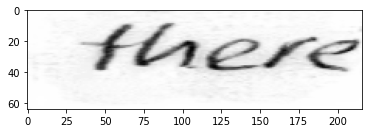

Destination in path /content/FakeRealWordDs3/test_fake_words, number of samples=2000
For example: /content/FakeRealWordDs3/test_fake_words/p03-142-05-05.png


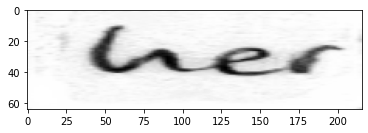

Destination in path /content/FakeRealWordDs3/val_fake_words, number of samples=2000
For example: /content/FakeRealWordDs3/val_fake_words/c04-122-06-10.png


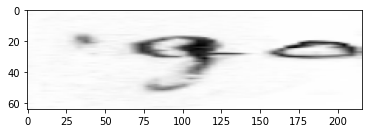

Destination in path /content/FakeRealWordDs3/train_real_words, number of samples=18000
For example: /content/FakeRealWordDs3/train_real_words/a01-038-01-01.png


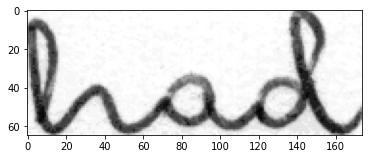

Destination in path /content/FakeRealWordDs3/val_real_words, number of samples=2000
For example: /content/FakeRealWordDs3/val_real_words/b05-032-04-03.png


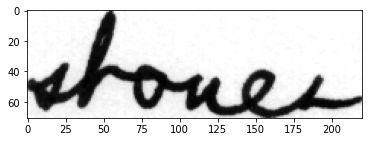

Destination in path /content/FakeRealWordDs3/test_real_words, number of samples=2000
For example: /content/FakeRealWordDs3/test_real_words/a05-108-02-03.png


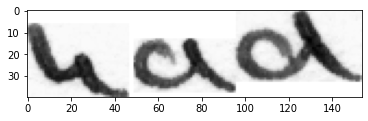


Number of all images: 44000


In [ ]:
def show_samples_from_new_ds(dest_paths):
    for dp in dest_paths:
        paths = glob(os.path.join(dp, "*"))
        random.shuffle(paths)
        print(f'Destination in path {dp}, number of samples={len(paths)}')
        i = random.randint(0, len(paths)-1)
        print(f'For example: {paths[i]}')
        plt.imshow(cv2.imread(paths[i], 0), cmap='gray')
        plt.show()

    print(f'\nNumber of all images: {sum([len(glob(os.path.join(dp, "*"))) for dp in dest_paths])}')

show_samples_from_new_ds(dest_paths)

# Filter word images by OCR test

In [ ]:
import time 
import json
import base64
import matplotlib.pyplot as plt
import requests
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
from matplotlib.lines import Line2D
from tqdm import tqdm
from google.colab import drive

%matplotlib inline 


# Variables

endpoint = 'https://eylonmiz.cognitiveservices.azure.com' # Endpoint from the Azure portal
subscription_key = '4cd378c142674845beb3c6103eb948c2' # One of the two keys coresponding with the above endpoint
text_recognition_url = endpoint + "/vision/v3.0/read/analyze" # Full analyzer path for the API request


def getOCRTextResult( operationLocation, headers ):
    """
    Helper function to get text result from operation location

    Parameters:
    operationLocation: operationLocation to get text result, See API Documentation
    headers: Used to pass the key information
    """

    retries = 0
    result = None

    while True:
        response = requests.request('get', operationLocation, json=None, data=None, headers=headers, params=None)
        
        if response.status_code == 429:
            print("Message: %s" % (response.json()))
            if retries <= _maxNumRetries:
                time.sleep(1)
                retries += 1
                continue
            else:
                print('Error: failed after retrying!')
                break
        elif response.status_code == 200:
            result = response.json()
        else:
            print("Error code: %d" % (response.status_code))
            print("Message: %s" % (response.json()))
        break

    return result

In [ ]:
def filter_words_by_ocr(src_reals_path, src_fakes_path, dest_reals_path, dest_fakes_path):
    
    if not os.path.exists(dest_reals_path):
        os.makedirs(dest_reals_path)
    if not os.path.exists(dest_fakes_path):
        os.makedirs(dest_fakes_path)
    
    real_paths = glob(os.path.join(src_reals_path, '*'))
    fake_paths = glob(os.path.join(src_fakes_path, '*'))

    for fp in tqdm(fake_paths):
        # Read the image into a byte array as the API expects 
        image_path = fp
        data = open(image_path, "rb").read()
        headers = {
            'Ocp-Apim-Subscription-Key': subscription_key,
            'Content-Type': 'application/octet-stream'
        }
        params = {'visualFeatures': 'Categories,Description,Color'}

        response = requests.post(
            text_recognition_url, headers=headers, params=params, data=data)
        response.raise_for_status()

        # Extracting text requires two API calls: One call to submit the
        # image for processing, the other to retrieve the text found in the image from the "Operation_Location" URL.

        # Holds the URI used to retrieve the recognized text.
        operation_url = response.headers["Operation-Location"]

        # The recognized text isn't immediately available, so poll to wait for completion.
        analysis = {}
        poll = True

        while (poll):
            response_final = requests.get(
                response.headers["Operation-Location"], headers=headers)
            analysis = response_final.json()
            
            print(json.dumps(analysis, indent=4))

            time.sleep(1)
            if ("analyzeResult" in analysis):
                poll = False
            if ("status" in analysis and analysis['status'] == 'failed'):
                poll = False

        operationLocation = response.headers["Operation-Location"]
        result1 = getOCRTextResult(operationLocation, headers)

        if len(result1['analyzeResult']['readResults'][0]['lines']) > 0:
            words = result1['analyzeResult']['readResults'][0]['lines'][0]['words']
            word_flag = True
            for w in words:
                if len(w['text']) <= 1:
                    word_flag = False
            if word_flag:
                img_name = fp.split('/')[-1]
                dest_fp = os.path.join(dest_fakes_path, img_name)
                src_rp = os.path.join(src_reals_path, img_name)
                dest_rp = os.path.join(dest_reals_path, img_name)
                if os.path.exists(dest_fp) and os.path.exists(src_rp) and os.path.exists(dest_rp):
                    copyfile(src_rp, dest_rp)
                    copyfile(fp, dest_fp)